In [1]:
from google.colab import drive

drive.mount('gdrive', force_remount=True)

Mounted at gdrive


In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
!unzip /content/gdrive/MyDrive/hd.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: labels/V_HELICOPTER_0391_092.txt  
  inflating: labels/V_AIRPLANE_0021_294.txt  
  inflating: labels/two_parrot_disco_1_3482.txt  
  inflating: labels/V_AIRPLANE_0551_157.txt  
  inflating: labels/99_2467.txt      
  inflating: labels/V_AIRPLANE_0501_196.txt  
  inflating: labels/V_HELICOPTER_0141_136.txt  
  inflating: labels/parrot_disco_distant_cross_2370.txt  
  inflating: labels/V_HELICOPTER_0501_266.txt  
  inflating: labels/parrot_disco_zoomin_zoomout_160.txt  
  inflating: labels/dji_mavick_distant_hillside_885.txt  
  inflating: labels/Clip_5_000832_crop_2.txt  
  inflating: labels/18_962.txt       
  inflating: labels/V_HELICOPTER_0461_190.txt  
  inflating: labels/augmented3_257.txt  
  inflating: labels/parrot_disco_distant_cross_2425.txt  
  inflating: labels/V_HELICOPTER_0131_060.txt  
  inflating: labels/15_606.txt       
  inflating: labels/V_HELICOPTER_0091_094.txt  
  inflating: labels/di

In [5]:
!unzip /content/gdrive/MyDrive/had.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: hackathon_additional_dataset/labels/matrice_600_2_1213.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_1216.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_122.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_1251.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_1254.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_1272.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_1308.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_1311.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_134.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_1345.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_1361.txt  
  inflating: hackathon_additional_dataset/labels/matrice_600_2_1368.txt  
  inflating: hackathon_additional_dataset/labe

In [6]:
len(os.listdir('/content/labels')), len(os.listdir('/content/images'))

(45000, 45000)

In [7]:
len(os.listdir('/content/hackathon_additional_dataset/labels')), len(os.listdir('/content/hackathon_additional_dataset/images'))

(22500, 22500)

## Вспомогательные функции

In [8]:
def yolo2common_coords(path, size, root_directory='/content/labels', plt_mode=False):
    '''
    Преобразует координаты в формате yolo в ненормированные координаты
    '''

    with open(f'{root_directory}/{path}', 'r') as fil:
        content = fil.read()

    yolo_coords = list(map(float, content.split()))

    center_x = yolo_coords[1] * size[1] # x * width
    center_y = yolo_coords[2] * size[0] # y * height

    width =  yolo_coords[3] * size[1] # norm_width * width
    height =  yolo_coords[4] * size[0] # norm_height * height

    if plt_mode:
        low_left_x = center_x - width / 2
        low_left_y = center_y - height / 2

        return (low_left_x, low_left_y, width, height)

    return (center_x, center_y, width, height)



In [9]:
def imgs_and_bbox(n_samples=1, root_directory='/content/images'):
    for i in range(n_samples):
        sample_n = random.randint(0, 45000)
        img_path = os.listdir(root_directory)[i]

        img = Image.open(f'{root_directory}/{img_path}')

        size = np.array(img).shape[:2]

        label_path = '.'.join(img_path.split('.')[:-1]) + '.txt'
        x, y, width, height = yolo2common_coords(label_path, size, plt_mode=True)

        fig, ax = plt.subplots()
        ax.imshow(img);

        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)

        plt.show()


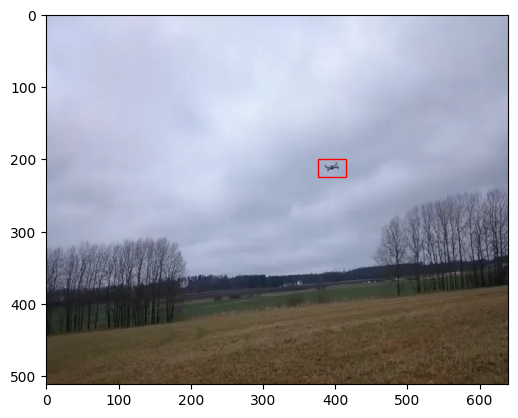

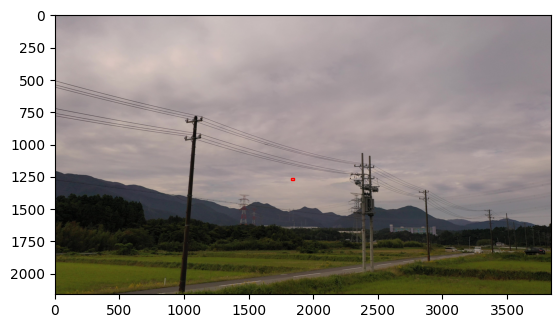

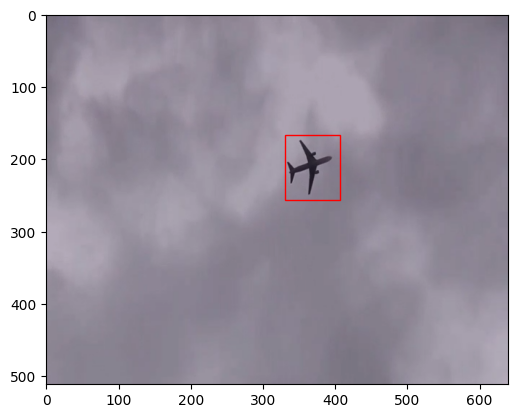

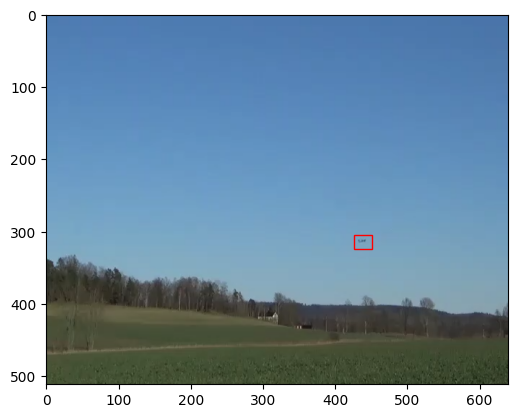

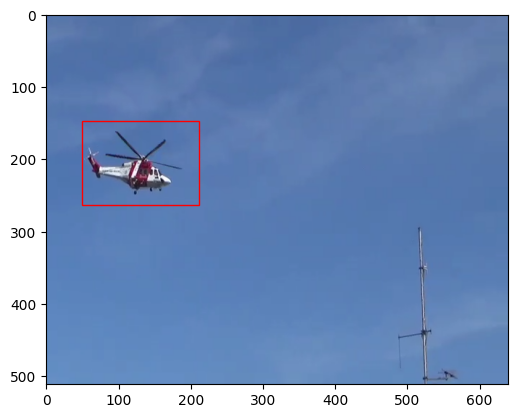

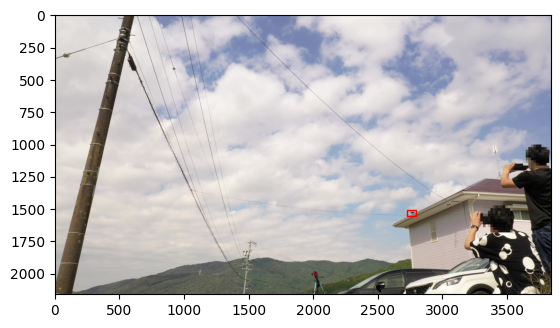

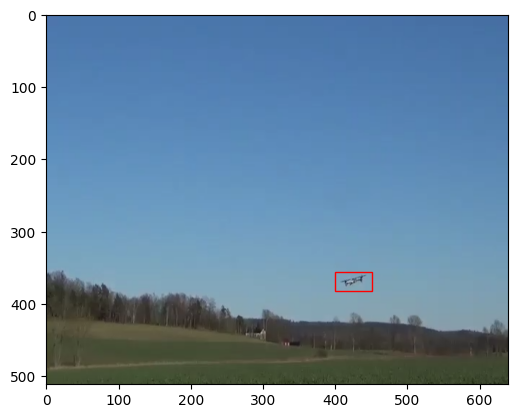

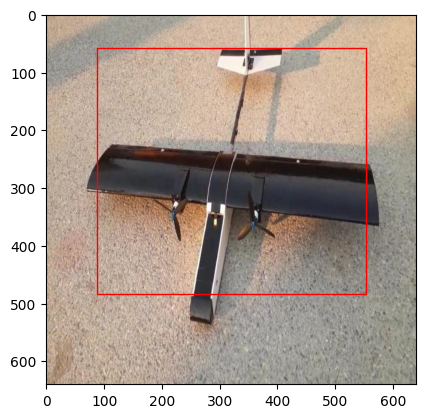

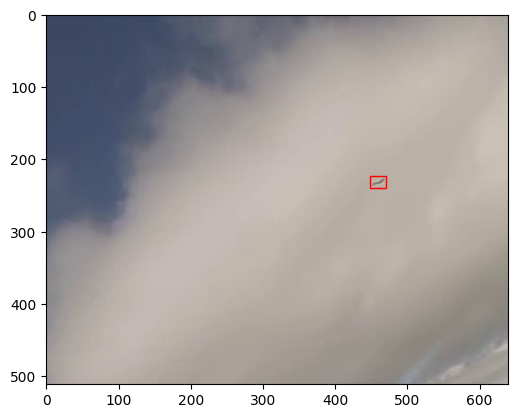

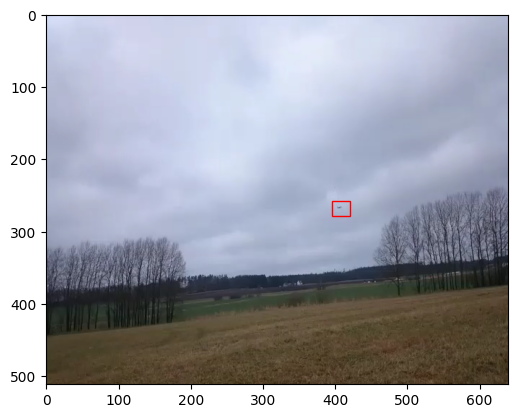

In [ ]:
import random

imgs_and_bbox(n_samples=10)

## train-val-test split (новый, StratifiedGroup)

In [10]:
second_ds_train = pd.read_csv('/content/second_dataset_train.csv')
second_ds_val = pd.read_csv('/content/second_dataset_val.csv')
second_ds_test = pd.read_csv('/content/second_dataset_test.csv')

In [ ]:
second_ds_train

,image_filename,video_label,object_label
0,00_06_10_to_00_06_27_278.png,4,0
1,00_06_10_to_00_06_27_284.png,4,0
2,00_06_10_to_00_06_27_304.png,4,0
3,00_06_10_to_00_06_27_313.png,4,0
4,00_06_10_to_00_06_27_327.png,4,0
...,...,...,...
11245,swarm_dji_phantom_492.png,748,0
11246,swarm_dji_phantom_757.png,748,0
11247,swarm_dji_phantom_911.png,748,0
11248,two_distant_phantom_671.png,751,0


### Создадим необходимые папки

In [11]:
dataset_folder = '/content/datasets/dataset_yolo'
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

In [12]:
image_folder, label_folder = f'{dataset_folder}/images', f'{dataset_folder}/labels'

if not os.path.exists(image_folder):
    os.mkdir(image_folder)

if not os.path.exists(label_folder):
    os.mkdir(label_folder)

In [13]:
for mode in ['train', 'val', 'test']:
    if not os.path.exists(f'{image_folder}/{mode}'):
        os.mkdir(f'{image_folder}/{mode}')
    if not os.path.exists(f'{label_folder}/{mode}'):
        os.mkdir(f'{label_folder}/{mode}')

### Переместим файлы из одного места в другое

In [14]:
first_dataset_labels_folder = '/content/labels'
first_dataset_images_folder = '/content/images'

In [15]:
first_dataset_labels_path = os.listdir(first_dataset_labels_folder)
first_dataset_images_path = os.listdir(first_dataset_images_folder)

In [16]:
train_images_dir = '/content/datasets/dataset_yolo/images/train'
val_images_dir = '/content/datasets/dataset_yolo/images/val'
test_images_dir = '/content/datasets/dataset_yolo/images/test'

train_labels_dir = '/content/datasets/dataset_yolo/labels/train'
val_labels_dir = '/content/datasets/dataset_yolo/labels/val'
test_labels_dir = '/content/datasets/dataset_yolo/labels/test'

In [17]:
import shutil

for first_dataset_label_path in first_dataset_labels_path:
      shutil.move(os.path.join(first_dataset_labels_folder, first_dataset_label_path),
                  train_labels_dir)

In [18]:
len(os.listdir('/content/labels')), len(os.listdir('/content/datasets/dataset_yolo/labels/train'))

(0, 45000)

In [19]:
for first_dataset_image_path in first_dataset_images_path:
      shutil.move(os.path.join(first_dataset_images_folder, first_dataset_image_path),
                  train_images_dir)

In [20]:
len(os.listdir('/content/images')), len(os.listdir('/content/datasets/dataset_yolo/images/train'))

(0, 45000)

In [21]:
second_dataset_labels_folder = '/content/hackathon_additional_dataset/labels'
second_dataset_images_folder = '/content/hackathon_additional_dataset/images'

In [ ]:
second_ds_train

,image_filename,video_label,object_label
0,00_06_10_to_00_06_27_278.png,4,0
1,00_06_10_to_00_06_27_284.png,4,0
2,00_06_10_to_00_06_27_304.png,4,0
3,00_06_10_to_00_06_27_313.png,4,0
4,00_06_10_to_00_06_27_327.png,4,0
...,...,...,...
11245,swarm_dji_phantom_492.png,748,0
11246,swarm_dji_phantom_757.png,748,0
11247,swarm_dji_phantom_911.png,748,0
11248,two_distant_phantom_671.png,751,0


In [22]:
for second_dataset_image_path in second_ds_train['image_filename'].values:
      shutil.move(os.path.join(second_dataset_images_folder, second_dataset_image_path),
                  train_images_dir)

In [23]:
len(os.listdir('/content/hackathon_additional_dataset/images')), len(os.listdir('/content/datasets/dataset_yolo/images/train'))

(11250, 56250)

In [24]:
for second_dataset_image_path in second_ds_train['image_filename'].values:
      second_dataset_label_path = ('.'.join(second_dataset_image_path.split('.')[:-1]) + '.txt')
      shutil.move(os.path.join(second_dataset_labels_folder, second_dataset_label_path),
                  train_labels_dir)

In [25]:
len(os.listdir('/content/hackathon_additional_dataset/labels')), len(os.listdir('/content/datasets/dataset_yolo/labels/train'))

(11250, 56250)

In [26]:
for second_dataset_image_path in second_ds_val['image_filename'].values:
      shutil.move(os.path.join(second_dataset_images_folder, second_dataset_image_path),
                  val_images_dir)

In [27]:
len(os.listdir('/content/hackathon_additional_dataset/images')), len(os.listdir('/content/datasets/dataset_yolo/images/val'))

(5625, 5625)

In [28]:
for second_dataset_image_path in second_ds_val['image_filename'].values:
      second_dataset_label_path = ('.'.join(second_dataset_image_path.split('.')[:-1]) + '.txt')
      shutil.move(os.path.join(second_dataset_labels_folder, second_dataset_label_path),
                  val_labels_dir)

In [29]:
len(os.listdir('/content/hackathon_additional_dataset/labels')), len(os.listdir('/content/datasets/dataset_yolo/labels/val'))

(5625, 5625)

In [30]:
for second_dataset_image_path in second_ds_test['image_filename'].values:
      shutil.move(os.path.join(second_dataset_images_folder, second_dataset_image_path),
                  test_images_dir)

In [31]:
len(os.listdir('/content/hackathon_additional_dataset/images')), len(os.listdir('/content/datasets/dataset_yolo/images/test'))

(0, 5625)

In [32]:
for second_dataset_image_path in second_ds_test['image_filename'].values:
      second_dataset_label_path = ('.'.join(second_dataset_image_path.split('.')[:-1]) + '.txt')
      shutil.move(os.path.join(second_dataset_labels_folder, second_dataset_label_path),
                  test_labels_dir)

In [33]:
len(os.listdir('/content/hackathon_additional_dataset/labels')), len(os.listdir('/content/datasets/dataset_yolo/labels/test'))

(0, 5625)

### Создадим файл data.yaml

In [34]:
import yaml

data = {'names': ['БПЛА коптерного типа', 'самолёт', 'вертолёт', 'птица', 'БПЛА самолётного типа'],
        'nc': 5, 'path': 'dataset_yolo', 'train': 'images/train', 'val': 'images/val', 'test': 'images/test'}

with open('/content/datasets/dataset_yolo/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [ ]:
# data.yaml - файл должен лежать в /content/datasets/dataset_yolo
'''
names:
- БПЛА коптерного типа
- самолёт
- вертолёт
- птица
- БПЛА самолётного типа
nc: 5
path: dataset_yolo
train: images/train
val: images/val
test: images/val
'''

## Train-test-split (старый, стратифицированный)

In [ ]:
dataset_folder = '/content/datasets/dataset_yolo'
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

In [ ]:
image_folder, label_folder = f'{dataset_folder}/images', f'{dataset_folder}/labels'
if not os.path.exists(image_folder):
    os.mkdir(image_folder)

if not os.path.exists(label_folder):
    os.mkdir(label_folder)

In [ ]:
for mode in ['train', 'val', 'test']:
    if not os.path.exists(f'{image_folder}/{mode}'):
        os.mkdir(f'{image_folder}/{mode}')
    if not os.path.exists(f'{label_folder}/{mode}'):
        os.mkdir(f'{label_folder}/{mode}')

In [ ]:
all_annotations = os.listdir('/content/labels')
labels_and_path = []

In [ ]:
for path in all_annotations:
    with open(f'/content/labels/{path}', 'r') as f:
        content = f.read()
    label = content[0]
    labels_and_path.append((label, path))


In [ ]:
labels_and_path

[('3', '11_286.txt'),
 ('3', '96_433.txt'),
 ('0', 'dji_phantom_4_mountain_hover_1457.txt'),
 ('2', 'V_HELICOPTER_0031_093.txt'),
 ('0', 'swarm_dji_phantom4_2_1574.txt'),
 ('4', '-_-_-34-_jpg.rf.a705eba216cb131a57260f337d9af7cb.txt'),
 ('3', '10_1822.txt'),
 ('1', '13556cf2022e3d1437dbfa7c7340d553.txt'),
 ('1', 'V_AIRPLANE_0161_051.txt'),
 ('0', '02_08_different_im___2023-08-02_9_frame0523.txt'),
 ('4', 'parrot_clear_birds_188.txt'),
 ('4', 'custom_fixed_wing_1_653.txt'),
 ('3', '10_1376.txt'),
 ('0', 'gopro_005_686.txt'),
 ('0', 'dji_matrice_210_hillside_545.txt'),
 ('4', 'parrot_disco_midrange_cross_2865.txt'),
 ('0', '1_im___DJI_0057.MP4_frame0090.txt'),
 ('4', 'justFlip1091.txt'),
 ('1', 'V_AIRPLANE_0521_046.txt'),
 ('3', '37_474.txt'),
 ('3', '38_365.txt'),
 ('4', 'custom_fixed_wing_1_899.txt'),
 ('4', 'parrot_disco_distant_cross_3_492.txt'),
 ('4', 'parrot_disco_distant_cross_259.txt'),
 ('4', 'two_parrot_disco_1_1138.txt'),
 ('1', 'V_AIRPLANE_0361_081.txt'),
 ('0', 'dji_phantom_

In [ ]:
labels = [t[0] for t in labels_and_path]
paths = [t[1] for t in labels_and_path]

In [ ]:
path_train, path_val, label_train, label_val = train_test_split(paths, labels,
                                                                random_state=22,
                                                                shuffle=True,
                                                                stratify=labels,
                                                                test_size=0.2)

In [ ]:
len(path_train), len(path_val)

(36000, 9000)

In [ ]:
import shutil

label_dir = '/content/labels'
for path in path_train:
    shutil.move(os.path.join(label_dir, path), '/content/datasets/dataset_yolo/labels/train')

In [ ]:
for path in path_val:
    shutil.move(os.path.join(label_dir, path), '/content/datasets/dataset_yolo/labels/val')

In [ ]:
len(os.listdir('/content/datasets/dataset_yolo/labels/train')), len(os.listdir('/content/datasets/dataset_yolo/labels/val'))

(36000, 9000)

In [ ]:
len(os.listdir('/content/labels'))

0

теперь надо найти в папке images изображение с таким же названием. Проблема в том, что у изображений разные расширения

In [ ]:
images_path = os.listdir('/content/images')

In [ ]:
images_train, images_val = [], []

In [ ]:
len(np.unique(np.array(path_train))), len(np.unique(np.array(path_val)))

(36000, 9000)

In [ ]:
len(np.unique(np.array(images_path)))

45000

In [ ]:
formats = set()
for img_path in images_path:
    formats.add(img_path.split('.')[-1])
print(formats)

{'JPEG', 'png', 'jpg'}


In [ ]:
from tqdm.auto import tqdm

# Уникальные форматы: 'jpg', 'png', 'JPEG'
for path in tqdm(path_train):
    for frmt in ['jpg', 'png', 'JPEG']:
        image_path = path[:-3] + frmt
        if image_path in images_path:
            img_idx = images_path.index(image_path)
            images_train.append(images_path[img_idx])

  0%|          | 0/36000 [00:00<?, ?it/s]

In [ ]:
len(images_train), len(np.unique(images_train))

(36000, 36000)

In [ ]:
for path in tqdm(path_val):
    for frmt in ['jpg', 'png', 'JPEG']:
        image_path = path[:-3] + frmt
        if image_path in images_path:
            img_idx = images_path.index(image_path)
            images_val.append(images_path[img_idx])

  0%|          | 0/9000 [00:00<?, ?it/s]

In [ ]:
len(images_val), len(np.unique(images_val))

(9000, 9000)

In [ ]:
image_dir = '/content/images'
for path in tqdm(images_train):
    shutil.move(os.path.join(image_dir, path), '/content/datasets/dataset_yolo/images/train')

  0%|          | 0/36000 [00:00<?, ?it/s]

In [ ]:
for path in tqdm(images_val):
    shutil.move(os.path.join(image_dir, path), '/content/datasets/dataset_yolo/images/val')

  0%|          | 0/9000 [00:00<?, ?it/s]

## обучение модели

In [35]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.8 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8m.pt')

results = model.train(data='/content/datasets/dataset_yolo/data.yaml', batch=16, epochs=100, imgsz=640)

100%|██████████| 49.7M/49.7M [00:00<00:00, 591MB/s]


Ultralytics YOLOv8.2.31 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/datasets/dataset_yolo/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

100%|██████████| 22.2M/22.2M [00:00<00:00, 511MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 383MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/dataset_yolo/labels/train... 56248 images, 0 backgrounds, 2 corrupt: 100%|██████████| 56250/56250 [04:11<00:00, 223.72it/s]

train: WARNING ⚠️ /content/datasets/dataset_yolo/images/train/2790a93ba1210aaaa09931b951d2376a.jpg: ignoring corrupt image/label: image file is truncated (1 bytes not processed)
train: WARNING ⚠️ /content/datasets/dataset_yolo/images/train/c95b4fd51b689de2f0d7b161b11b7c9e.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /content/datasets/dataset_yolo/images/train/e704da53011ed94a1644bec7ffc904e9.jpg: ignoring corrupt image/label: image file is truncated (4 bytes not processed)


train: New cache created: /content/datasets/dataset_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/dataset_yolo/labels/val... 5625 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5625/5625 [00:31<00:00, 181.26it/s]

val: WARNING ⚠️ /content/datasets/dataset_yolo/images/val/4f6335afb880904ed5ebae7ed55fd81b.jpg: corrupt JPEG restored and saved


val: New cache created: /content/datasets/dataset_yolo/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.36G      2.081      10.27      1.772         27        640:   1%|          | 18/3516 [00:04<09:19,  6.25it/s]

      1/100      7.36G      2.135      10.78      1.761         26        640:   1%|          | 31/3516 [00:07<10:26,  5.56it/s]
100%|██████████| 755k/755k [00:00<00:00, 97.9MB/s]
      1/100      7.37G      1.515      1.881      1.259         13        640: 100%|██████████| 3516/3516 [10:25<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:01<00:00,  2.88it/s]

                   all       5625       5663      0.674      0.553      0.593      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.13G      1.553      1.361      1.274         15        640: 100%|██████████| 3516/3516 [13:06<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


                   all       5625       5663      0.875      0.632      0.689      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.13G      1.685      1.553      1.358         14        640: 100%|██████████| 3516/3516 [12:45<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:45<00:00,  3.88it/s]


                   all       5625       5663      0.806      0.604      0.665      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.22G      1.675      1.524      1.364         15        640: 100%|██████████| 3516/3516 [12:06<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


                   all       5625       5663      0.854      0.678      0.718      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.21G      1.577      1.348      1.317          9        640: 100%|██████████| 3516/3516 [12:22<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:51<00:00,  3.43it/s]


                   all       5625       5663      0.882      0.709      0.737      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.22G       1.51      1.244      1.283         16        640: 100%|██████████| 3516/3516 [13:09<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:55<00:00,  3.15it/s]


                   all       5625       5663      0.914      0.721      0.752       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       7.2G      1.467      1.181      1.262         17        640: 100%|██████████| 3516/3516 [13:30<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:49<00:00,  3.57it/s]


                   all       5625       5663      0.926      0.733      0.757      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.22G      1.424      1.128       1.24         17        640: 100%|██████████| 3516/3516 [13:27<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:50<00:00,  3.46it/s]

                   all       5625       5663      0.924      0.735      0.762      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.21G      1.402      1.084      1.226         13        640: 100%|██████████| 3516/3516 [13:10<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:50<00:00,  3.50it/s]

                   all       5625       5663      0.911      0.747      0.765      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       7.2G      1.381      1.055      1.213          8        640: 100%|██████████| 3516/3516 [12:53<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:49<00:00,  3.54it/s]


                   all       5625       5663      0.917      0.746      0.767      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.21G      1.352      1.025      1.198         12        640: 100%|██████████| 3516/3516 [13:42<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:52<00:00,  3.33it/s]


                   all       5625       5663      0.913      0.749       0.77       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       7.2G      1.333      1.001      1.189         22        640: 100%|██████████| 3516/3516 [13:36<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:53<00:00,  3.31it/s]

                   all       5625       5663      0.932      0.753      0.774      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       7.2G       1.32     0.9756      1.182         18        640: 100%|██████████| 3516/3516 [13:43<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:52<00:00,  3.34it/s]

                   all       5625       5663      0.932      0.755      0.776      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       7.2G      1.301     0.9624      1.175         16        640: 100%|██████████| 3516/3516 [13:37<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:55<00:00,  3.18it/s]


                   all       5625       5663       0.93      0.757      0.777      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.21G      1.291     0.9477      1.173         17        640: 100%|██████████| 3516/3516 [13:23<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:51<00:00,  3.40it/s]

                   all       5625       5663      0.934      0.756      0.778      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       7.2G      1.278     0.9324      1.168         19        640: 100%|██████████| 3516/3516 [13:41<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:53<00:00,  3.29it/s]

                   all       5625       5663      0.938      0.758       0.78      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.19G       1.27     0.9196      1.157         17        640: 100%|██████████| 3516/3516 [13:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:51<00:00,  3.40it/s]


                   all       5625       5663      0.944      0.758      0.782      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.21G      1.264     0.9084      1.156         10        640: 100%|██████████| 3516/3516 [13:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:56<00:00,  3.14it/s]

                   all       5625       5663      0.944       0.76      0.782      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.21G      1.253     0.8942       1.15         31        640: 100%|██████████| 3516/3516 [13:33<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:55<00:00,  3.17it/s]

                   all       5625       5663      0.943       0.76      0.782       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       7.2G      1.239     0.8824      1.144         15        640: 100%|██████████| 3516/3516 [13:36<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:00<00:00,  2.91it/s]


                   all       5625       5663      0.942      0.759      0.781      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       7.2G       1.23     0.8693      1.142         21        640: 100%|██████████| 3516/3516 [13:53<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:52<00:00,  3.34it/s]

                   all       5625       5663      0.941       0.76      0.782      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.21G      1.221     0.8661      1.138         11        640: 100%|██████████| 3516/3516 [14:22<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:54<00:00,  3.26it/s]

                   all       5625       5663      0.938      0.761      0.782      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       7.2G      1.214     0.8587      1.131         13        640: 100%|██████████| 3516/3516 [13:50<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:50<00:00,  3.47it/s]

                   all       5625       5663      0.941      0.763      0.783      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       7.2G      1.211     0.8425      1.128         11        640: 100%|██████████| 3516/3516 [13:57<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:51<00:00,  3.40it/s]

                   all       5625       5663       0.94      0.764      0.784       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.21G      1.205     0.8431      1.128         15        640: 100%|██████████| 3516/3516 [14:35<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:00<00:00,  2.92it/s]

                   all       5625       5663      0.942      0.764      0.785      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       7.2G      1.195     0.8254      1.122         12        640: 100%|██████████| 3516/3516 [14:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:58<00:00,  2.99it/s]


                   all       5625       5663      0.939      0.765      0.785      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       7.2G      1.192     0.8226       1.12          8        640: 100%|██████████| 3516/3516 [13:51<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:52<00:00,  3.32it/s]

                   all       5625       5663       0.94      0.765      0.786      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.18G      1.185     0.8206      1.114         16        640: 100%|██████████| 3516/3516 [14:18<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:56<00:00,  3.12it/s]

                   all       5625       5663      0.939      0.765      0.786      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       7.2G      1.172     0.8122      1.115         11        640: 100%|██████████| 3516/3516 [14:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:54<00:00,  3.26it/s]


                   all       5625       5663      0.938      0.766      0.787       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       7.2G      1.168     0.7997      1.109         20        640: 100%|██████████| 3516/3516 [14:22<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:58<00:00,  3.01it/s]


                   all       5625       5663      0.939      0.766      0.787      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.21G      1.163     0.7936      1.105         19        640: 100%|██████████| 3516/3516 [14:25<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:00<00:00,  2.89it/s]

                   all       5625       5663      0.938      0.766      0.787      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       7.2G      1.153     0.7923      1.105         23        640: 100%|██████████| 3516/3516 [14:13<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:52<00:00,  3.36it/s]

                   all       5625       5663      0.938      0.766      0.788      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.21G      1.152     0.7897      1.098         15        640: 100%|██████████| 3516/3516 [14:44<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:57<00:00,  3.05it/s]

                   all       5625       5663      0.939      0.765      0.787      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       7.2G      1.149     0.7792      1.098          9        640: 100%|██████████| 3516/3516 [14:18<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:58<00:00,  3.02it/s]

                   all       5625       5663      0.947      0.764      0.787       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.18G      1.147     0.7792      1.098         11        640: 100%|██████████| 3516/3516 [14:41<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:55<00:00,  3.19it/s]

                   all       5625       5663      0.945      0.765      0.788      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.18G      1.132     0.7719      1.094         15        640: 100%|██████████| 3516/3516 [14:19<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:04<00:00,  2.71it/s]

                   all       5625       5663      0.945      0.766      0.789      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.19G      1.126     0.7643      1.089         15        640: 100%|██████████| 3516/3516 [14:45<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [00:57<00:00,  3.08it/s]


                   all       5625       5663      0.946      0.766      0.789      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       7.2G      1.124     0.7597       1.09         32        640:  42%|████▏     | 1483/3516 [06:25<05:12,  6.50it/s]